**Installs**

In [ ]:
# Core dependencies
#pip install pandas numpy scikit-learn matplotlib seaborn tqdm nltk spacy

# For Word2Vec and Doc2Vec
#pip install gensim==4.3.2

# For SBERT
#pip install sentence-transformers==2.2.2 transformers==4.30.2 torch==2.0.1 huggingface_hub==0.14.1

# Download NLTK and spaCy data (one-time)
#python -m nltk.downloader punkt
#python -m spacy download en_core_web_sm


**Imports**

In [ ]:
import re
import gc
import ast

import pandas as pd
import numpy as np

import nltk
import spacy
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from gensim.models import KeyedVectors, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import gensim.downloader as api
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


**Light Preprocessing for dense embeddings**



In [ ]:
# Load only needed columns
df = pd.read_parquet(
    '/content/drive/MyDrive/NLP News Bias Data/data_newsbias_cleaned.parquet',
    columns=['text', 'bias_label']
)
df = df.dropna(subset=['text', 'bias_label']).copy()

# Light cleaning for Word2Vec/GloVe
def clean_for_embeddings(text):
    text = text.lower()                         # Lowercase
    text = re.sub(r'\s+', ' ', text)            # Normalize whitespace
    return text.strip()

# Apply to DataFrame
df['text_clean_embed'] = df['text'].astype(str).apply(clean_for_embeddings)

# Keep only what you need
df_cleaned_embed = df[['text_clean_embed', 'bias_label']]

# Save to Parquet
df_cleaned_embed.to_parquet(
    '/content/drive/MyDrive/NLP News Bias Data/df_cleaned_for_embeddings.parquet',
    compression='snappy'
)

print(f"Cleaned (for embeddings) data saved: {df_cleaned_embed.shape[0]} rows")

KeyboardInterrupt: 

**Download Word2Vec News**

In [ ]:
print("Downloading Word2Vec (Google News 300)...")
word2vec_model = api.load("word2vec-google-news-300")
print("Word2Vec model loaded.")

Word2Vec model loaded.


**Building Averages of the word vectors for each article (document)**

In [ ]:
import numpy as np

def vectorize_text(text, model, dim=300):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    if not vectors:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

**Vectorize with Word2Vec Google News**

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/NLP News Bias Data/df_cleaned_for_embeddings.parquet')

batch_size = 100_000
embeddings = []
labels = []

for start in range(0, len(df), batch_size):
    end = min(start + batch_size, len(df))
    batch = df.iloc[start:end]

    print(f"Processing rows {start}–{end}...")

    batch_vectors = np.vstack(batch['text_clean_embed'].apply(lambda x: vectorize_text(x, word2vec_model)).values)
    embeddings.append(batch_vectors)
    labels.extend(batch['bias_label'].values)

    del batch, batch_vectors
    gc.collect()

# Combine all
X = np.vstack(embeddings)
y = np.array(labels)

print(f"Vectorization complete: shape {X.shape}")

KeyboardInterrupt: 

**Train and evaluate a Logistic Regression Classifier**

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train
clf = LogisticRegression(max_iter=500, solver='saga')
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

**MLP with Word2Vec**

In [ ]:
def vectorize_text(text, model, dim=300):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    if not vectors:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/NLP News Bias Data/df_cleaned_for_embeddings.parquet')

# Ensure labels are strings
df['bias_label'] = df['bias_label'].astype(str)

# Sample 50k per label (stratified sampling)
df_sampled = (
    df.groupby('bias_label', group_keys=False)
      .apply(lambda g: g.sample(50_000, random_state=42))
      .reset_index(drop=True)
)

print(df_sampled['bias_label'].value_counts())

bias_label
center    50000
left      50000
right     50000
Name: count, dtype: int64


<ipython-input-6-a2937e52af62>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(50_000, random_state=42))


In [ ]:
batch_size = 50_000  # just 3 batches of 50k = 150k total
embeddings = []
labels = []

for start in range(0, len(df_sampled), batch_size):
    end = min(start + batch_size, len(df_sampled))
    batch = df_sampled.iloc[start:end]

    print(f"Processing rows {start}–{end}...")

    batch_vectors = np.vstack(batch['text_clean_embed'].apply(
        lambda x: vectorize_text(x, word2vec_model)
    ).values)

    embeddings.append(batch_vectors)
    labels.extend(batch['bias_label'].values)

    del batch, batch_vectors
    gc.collect()

# Combine
X = np.vstack(embeddings)
y = np.array(labels)

Processing rows 0–50000...
Processing rows 50000–100000...
Processing rows 100000–150000...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

mlp = MLPClassifier(hidden_layer_sizes=(300,), max_iter=50, random_state=42)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(300,), max_iter=50, random_state=42)


🎯 Accuracy: 0.5849

📋 Classification Report:

              precision    recall  f1-score   support

      center       0.55      0.62      0.59     10000
        left       0.61      0.65      0.63     10000
       right       0.59      0.49      0.53     10000

    accuracy                           0.58     30000
   macro avg       0.59      0.58      0.58     30000
weighted avg       0.59      0.58      0.58     30000



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


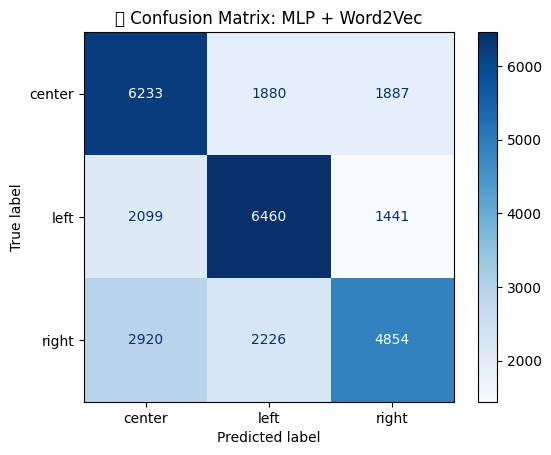

In [ ]:
# Predict on test set
y_pred = mlp.predict(X_test)

# Accuracy
print("\nAccuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix: MLP + Word2Vec")
plt.grid(False)
plt.show()

**Gridsearch for MLP with Word2Vec**

Fitting 3 folds for each of 36 candidates, totalling 108 fits

🔍 Best Parameters:
{'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (300, 100), 'mlp__learning_rate_init': 0.01}

🎯 Accuracy: 0.5689666666666666

📋 Classification Report:
               precision    recall  f1-score   support

      center       0.58      0.50      0.53     10000
        left       0.59      0.66      0.62     10000
       right       0.54      0.55      0.55     10000

    accuracy                           0.57     30000
   macro avg       0.57      0.57      0.57     30000
weighted avg       0.57      0.57      0.57     30000



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


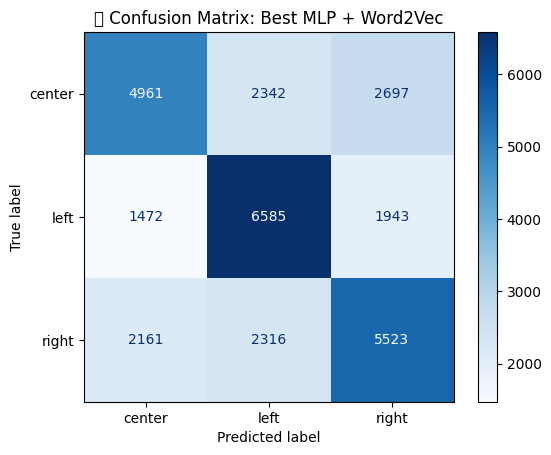

In [ ]:
# Optional: scale the Word2Vec vectors (can help MLP)
scaler = StandardScaler()

# MLP pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('mlp', MLPClassifier(max_iter=100, random_state=42))
])

# Grid search parameter space
param_grid = {
    'mlp__hidden_layer_sizes': [(100,), (300,), (300, 100)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01]
}

# Grid search setup
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

# Run search
grid_search.fit(X_train, y_train)

# Best params
print("\nBest Parameters:")
print(grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix: Best MLP + Word2Vec")
plt.grid(False)
plt.show()


**SBERT Embeddings**

<ipython-input-1-780fedfab84c>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(50_000, random_state=42), include_groups=True)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


⚙️ Encoding with SBERT...


Batches:   0%|          | 0/4688 [00:00<?, ?it/s]

Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Best parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (512, 256)}

🎯 Accuracy: 0.5222333333333333

📋 Classification Report:
               precision    recall  f1-score   support

      center       0.52      0.54      0.53     10000
        left       0.54      0.52      0.53     10000
       right       0.51      0.51      0.51     10000

    accuracy                           0.52     30000
   macro avg       0.52      0.52      0.52     30000
weighted avg       0.52      0.52      0.52     30000



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


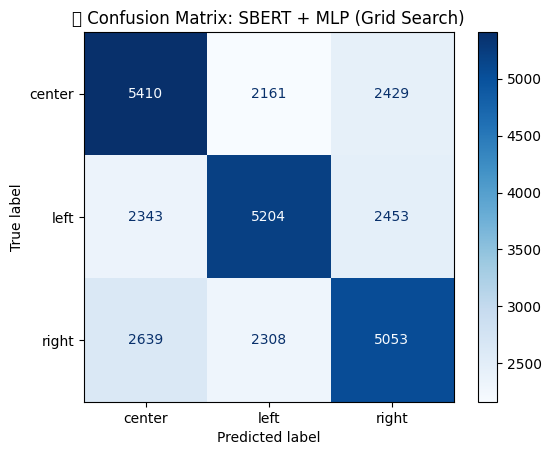

In [ ]:
# Load cleaned dataset
df = pd.read_parquet('/content/drive/MyDrive/NLP News Bias Data/data_newsbias_cleaned.parquet')

# Drop missing and ensure label is string
df = df.dropna(subset=['text', 'bias_label']).copy()
df['bias_label'] = df['bias_label'].astype(str)


# Balanced sampling: 50k per class
df_sampled = (
    df.groupby('bias_label', group_keys=False)
      .apply(lambda g: g.sample(50_000, random_state=42), include_groups=True)
      .reset_index(drop=True)
)

texts = df_sampled['text'].astype(str).tolist()
labels = df_sampled['bias_label'].values


# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all documents (batch, GPU-compatible)
embeddings = model.encode(texts, show_progress_bar=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, stratify=labels, test_size=0.2, random_state=42
)

# Optional: scale features for MLP stability
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=100, early_stopping=False, n_iter_no_change=5, random_state=42))
])

# Define grid
param_grid = {
    "mlp__hidden_layer_sizes": [(100,), (300,), (512, 256)],
    "mlp__activation": ["relu"],
    "mlp__alpha": [0.0001, 0.001]
}

# Run grid search
grid = GridSearchCV(
    pipeline, param_grid,
    cv=3, verbose=2, n_jobs=-1, scoring="accuracy"
)
grid.fit(X_train, y_train)

# Best model
print("Best parameters:", grid.best_params_)

# Evaluate
y_pred = grid.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix: SBERT + MLP (Grid Search)")
plt.grid(False)
plt.show()



**SBERT with Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)


🎯 Accuracy: 0.5321666666666667

📋 Classification Report:
               precision    recall  f1-score   support

      center       0.53      0.54      0.53     10000
        left       0.56      0.55      0.56     10000
       right       0.51      0.51      0.51     10000

    accuracy                           0.53     30000
   macro avg       0.53      0.53      0.53     30000
weighted avg       0.53      0.53      0.53     30000



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


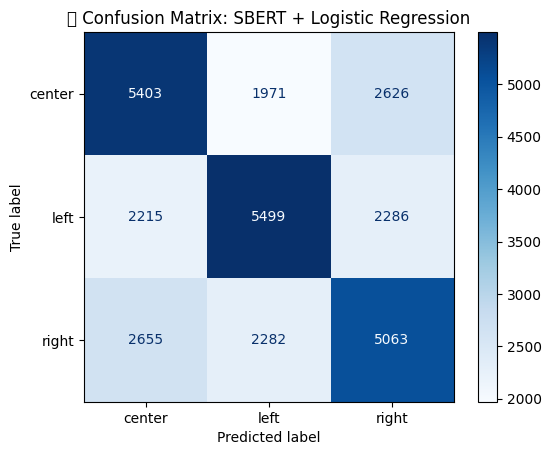

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix: SBERT + Logistic Regression")
plt.grid(False)
plt.show()

**Logistic Regression with optimized SBERT**

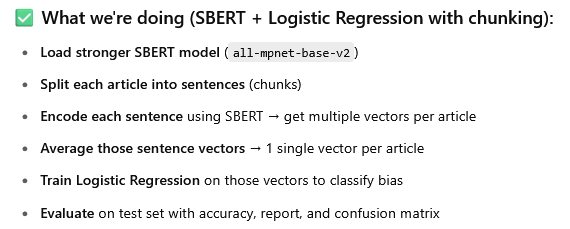

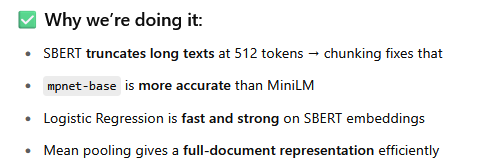

**Chunked SBERT + Logistic Regression**

In [ ]:
# Load your cleaned dataset again
df = pd.read_parquet('/content/drive/MyDrive/NLP News Bias Data/data_newsbias_cleaned.parquet')

# Drop missing and ensure label is string
df = df.dropna(subset=['text', 'bias_label']).copy()
df['bias_label'] = df['bias_label'].astype(str)

# Balanced sampling: 50k per class
df_sampled = (
    df.groupby('bias_label', group_keys=False)
      .apply(lambda g: g.sample(50_000, random_state=42), include_groups=True)
      .reset_index(drop=True)
)

<ipython-input-2-a62b84654405>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(50_000, random_state=42), include_groups=True)


In [ ]:
# Download punkt if not already present
#nltk.download('punkt', quiet=True)

# Load stronger SBERT model
model = SentenceTransformer("all-mpnet-base-v2")

def chunk_and_encode(text, max_sentences=20):
    """
    Splits text into sentences and encodes them with SBERT.
    Then returns the mean-pooled document vector.
    """
    sentences = sent_tokenize(text)
    sentences = sentences[:max_sentences]

    if not sentences:
        return np.zeros(model.get_sentence_embedding_dimension())

    sentence_embeddings = model.encode(sentences)
    return np.mean(sentence_embeddings, axis=0)

# Input texts and labels
texts = df_sampled['text'].astype(str).tolist()
labels = df_sampled['bias_label'].astype(str).values

# Encode with clean progress bar
print("⚙️ Encoding chunked articles...")
embeddings = np.vstack([
    chunk_and_encode(text)
    for text in tqdm(texts, desc="Progress", ncols=80, dynamic_ncols=False)
])

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, stratify=labels, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate
print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("📊 Confusion Matrix: Chunked SBERT + LR")
plt.grid(False)
plt.show()

NameError: name 'embeddings' is not defined

Automatically extract the most frequent and distinctive words from left and right news articles, then plot their Word2Vec embeddings to analyze ideological clustering.

In [ ]:
# Load pretrained Word2Vec model

print("Downloading Word2Vec (Google News 300)...")
word2vec = api.load("word2vec-google-news-300")
print("Word2Vec model loaded.")


# Load cleaned dataset (adjust path as needed)
df = pd.read_parquet('/content/drive/MyDrive/NLP News Bias Data/df_cleaned_model_ready.parquet')
df = df[df['bias_label'].isin(['left', 'right'])].copy()

# Balance: sample 500k per class
df = (
    df.groupby('bias_label', group_keys=False)
      .apply(lambda g: g.sample(500000, random_state=42))
      .reset_index(drop=True)
)

# Split into left and right texts
left_texts = df[df['bias_label'] == 'left']['text_clean']
right_texts = df[df['bias_label'] == 'right']['text_clean']

# Extract top N words using CountVectorizer
def get_top_words(texts, top_n=500):
    vec = CountVectorizer(stop_words='english', max_features=top_n)
    X = vec.fit_transform(texts)
    return set(vec.get_feature_names_out())

top_left_words = get_top_words(left_texts)
top_right_words = get_top_words(right_texts)

# Remove overlapping words
left_unique = top_left_words - top_right_words
right_unique = top_right_words - top_left_words


# Keep only words present in Word2Vec
left_valid = [w for w in left_unique if w in word2vec]
right_valid = [w for w in right_unique if w in word2vec]

# Prepare final data
words = left_valid + right_valid
labels = ['left'] * len(left_valid) + ['right'] * len(right_valid)
vectors = np.array([word2vec[w] for w in words])

# Reduce to 2D using PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], hue=labels, palette="Set1", s=80, alpha=0.8)

# Annotate words
#for i, word in enumerate(words):
    #plt.text(vectors_2d[i, 0]+0.2, vectors_2d[i, 1]+0.1, word, fontsize=8)

plt.title("Word2Vec Embeddings of Distinctive Left vs Right Words (Google News)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(title="Bias Class")
plt.tight_layout()
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

**Compare Left/Right Words in Word2Vec Space**

<ipython-input-6-596b4affc64d>:67: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


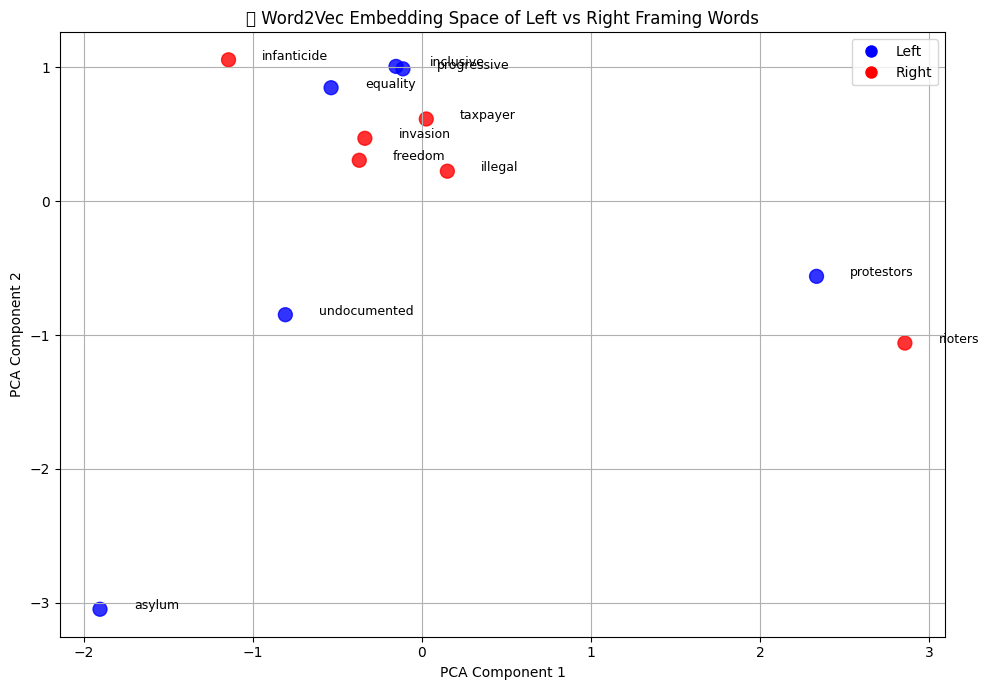

In [ ]:
# Load pretrained Google News Word2Vec
word2vec = api.load("word2vec-google-news-300")

# Define word lists (based on literature)
left_words_raw = [
    "undocumented", "protestors", "asylum", "equality", "inclusive", "progressive"
]

right_words_raw = [
    "illegal", "rioters", "invasion", "freedom", "infanticide", "taxpayer"
]

# Handle multi-word fallback
def resolve_word_embedding(phrase, model):
    if phrase in model:
        return phrase, model[phrase]
    tokens = phrase.replace("_", " ").split()
    vecs = [model[w] for w in tokens if w in model]
    if vecs:
        return phrase, np.mean(vecs, axis=0)
    else:
        return phrase, None

# Resolve all vectors
words, labels, vectors = [], [], []
for w in left_words_raw:
    name, vec = resolve_word_embedding(w, word2vec)
    if vec is not None:
        words.append(name)
        vectors.append(vec)
        labels.append('left')

for w in right_words_raw:
    name, vec = resolve_word_embedding(w, word2vec)
    if vec is not None:
        words.append(name)
        vectors.append(vec)
        labels.append('right')

# PCA to 2D
vectors = np.array(vectors)
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue' if l == 'left' else 'red' for l in labels]
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=colors, s=100, alpha=0.8)

# Annotate
for i, word in enumerate(words):
    plt.text(vectors_2d[i, 0] + 0.2, vectors_2d[i, 1], word.replace("_", " "), fontsize=9)

plt.title("Word2Vec Embedding Space of Left vs Right Framing Words")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Left', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Right', markerfacecolor='red', markersize=10)
])
plt.tight_layout()
plt.show()
